In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import log_loss, classification_report, accuracy_score
from xgboost import XGBRFClassifier, XGBClassifier
import matplotlib.pyplot as plt

In [6]:
df_all = pd.read_csv('enriched_data.csv')

X_train = df_all[df_all['Season'] < 2024].drop(columns = ['Season', 'ScoreDiff', 'Winner', 'TeamID0_', 'TeamID1_'])
y_train = df_all[df_all['Season'] < 2024]['Winner']

X_test = df_all[df_all['Season'] == 2024].drop(columns = ['Season', 'ScoreDiff', 'Winner', 'TeamID0_', 'TeamID1_'])
y_test = df_all[df_all['Season'] == 2024]['Winner']

odds_df = pd.read_csv('odds.csv')
odds_df = pd.concat([odds_df.rename(columns = {'team1': 'TeamID0_', 
                                               'team2': 'TeamID1_',
                                               'team1ret': 'ret0',
                                               'team2ret': 'ret1',
                                               }), 
                                    odds_df.rename(columns = {'team1': 'TeamID1_', 
                                                              'team2': 'TeamID0_',
                                                              'team1ret': 'ret1',
                                                              'team2ret': 'ret0',})], 
                                    axis = 0)

In [54]:
param_grid = {
 
}

grid_search = GridSearchCV(XGBClassifier(max_depth = 7,
                                         min_child_weight = 1,
                                         gamma = 0,
                                         subsample = 0.77,
                                         colsample_bytree = 0.94,
                                         reg_alpha = 0.055
                                         ), 
                            param_grid=param_grid,
                            scoring = 'accuracy',
                            n_jobs=8) 
grid_search.fit(X_train, y_train)

xgb = grid_search.best_estimator_

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.611729,0.010097,0.005824,0.000135,{},0.695817,0.714829,0.642586,0.703422,0.665399,0.684411,0.026562,1


In [55]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
print(classification_report(y_test, y_pred))

df_2024 = df_all[df_all['Season'] == 2024]
df_2024.loc[:, ['prob0', 'prob1']] = y_prob
df_2024 = df_2024.merge(odds_df, how = 'inner',)

df_bets = df_2024[['Winner', 'ret0', 'ret1', 'prob0', 'prob1']]
df_bets['eff_ret_0'] = df_bets['ret0'] * df_bets['prob0'] - df_bets['prob1']
df_bets['eff_ret_1'] = df_bets['ret1'] * df_bets['prob1'] - df_bets['prob0']
df_bets['to_bet'] = df_bets[['eff_ret_0', 'eff_ret_1']].idxmax(axis = 1).str[-1:].astype(int)
df_bets['winnings'] = 0.0
df_bets.loc[((df_bets['Winner'] == 0) & (df_bets['to_bet'] == 0)), 'winnings'] = df_bets['ret0']
df_bets.loc[((df_bets['Winner'] == 1) & (df_bets['to_bet'] == 1)), 'winnings'] = df_bets['ret1']
df_bets.loc[(df_bets['Winner'] != df_bets['to_bet']), 'winnings'] = -1
df_bets.loc[(df_bets[['eff_ret_0', 'eff_ret_1']].max(axis = 1) <= 0), 'winnings'] = 0

df_bets['winnings'].sum()

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        35
           1       0.73      0.75      0.74        32

    accuracy                           0.75        67
   macro avg       0.75      0.75      0.75        67
weighted avg       0.75      0.75      0.75        67



/tmp/ipykernel_1420/2892798570.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bets['eff_ret_0'] = df_bets['ret0'] * df_bets['prob0'] - df_bets['prob1']
/tmp/ipykernel_1420/2892798570.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bets['eff_ret_1'] = df_bets['ret1'] * df_bets['prob1'] - df_bets['prob0']
/tmp/ipykernel_1420/2892798570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

-3.0845553212478056

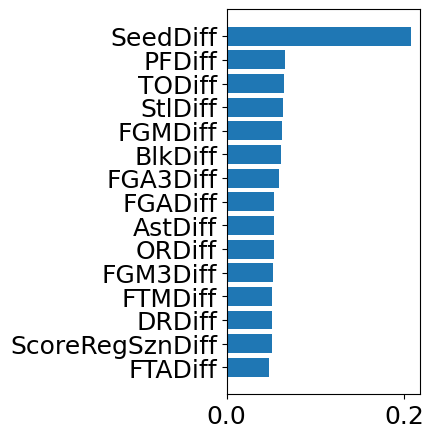

In [71]:
sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize = (2.5,5))
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.rcParams['font.size'] = 18
plt.show()

In [56]:
param_grid = { 
    'n_estimators': range(400,451, 5),
} 

grid_search = GridSearchCV(RandomForestClassifier(max_features = 3,
                                                  n_estimators = 420,
                                                  ), 
                            param_grid=param_grid,
                            scoring = 'accuracy',
                            n_jobs=8) 
grid_search.fit(X_train, y_train)

rf = grid_search.best_estimator_

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.552907,0.024937,0.030108,0.003360,400,{'n_estimators': 400},0.730038,0.714829,0.627376,0.688213,0.669202,0.685932,0.036040,7
1,1.558603,0.069457,0.031547,0.008598,405,{'n_estimators': 405},0.711027,0.718631,0.642586,0.692015,0.661597,0.685171,0.028997,10
2,1.596425,0.103476,0.029621,0.002287,410,{'n_estimators': 410},0.726236,0.741445,0.612167,0.692015,0.669202,0.688213,0.045691,3
3,1.445793,0.019313,0.026151,0.000410,415,{'n_estimators': 415},0.737643,0.726236,0.619772,0.688213,0.665399,0.687452,0.042640,4
4,1.537156,0.053062,0.033793,0.004576,420,{'n_estimators': 420},0.711027,0.707224,0.627376,0.695817,0.657795,0.679848,0.032299,11
5,1.511825,0.078467,0.031054,0.004077,425,{'n_estimators': 425},0.718631,0.733840,0.642586,0.695817,0.676806,0.693536,0.032048,1
6,1.624233,0.022365,0.029890,0.002577,430,{'n_estimators': 430},0.722433,0.733840,0.619772,0.692015,0.688213,0.691255,0.039762,2
7,1.651055,0.026252,0.031761,0.003060,435,{'n_estimators': 435},0.699620,0.722433,0.627376,0.695817,0.684411,0.685932,0.031776,7
8,1.683019,0.058911,0.036521,0.006481,440,{'n_estimators': 440},0.722433,0.730038,0.623574,0.692015,0.661597,0.685932,0.039485,7
9,1.833995,0.021753,0.034797,0.008632,445,{'n_estimators': 445},0.711027,0.718631,0.642586,0.688213,0.673004,0.686692,0.027376,6


In [50]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        35
           1       0.72      0.72      0.72        32

    accuracy                           0.73        67
   macro avg       0.73      0.73      0.73        67
weighted avg       0.73      0.73      0.73        67



In [51]:
df_2024 = df_all[df_all['Season'] == 2024]
df_2024.loc[:, ['prob0', 'prob1']] = y_prob
df_2024 = df_2024.merge(odds_df, how = 'inner',)

df_bets = df_2024[['Winner', 'ret0', 'ret1', 'prob0', 'prob1']]
df_bets['eff_ret_0'] = df_bets['ret0'] * df_bets['prob0'] - df_bets['prob1']
df_bets['eff_ret_1'] = df_bets['ret1'] * df_bets['prob1'] - df_bets['prob0']
df_bets['to_bet'] = df_bets[['eff_ret_0', 'eff_ret_1']].idxmax(axis = 1).str[-1:].astype(int)
df_bets['winnings'] = 0.0
df_bets.loc[((df_bets['Winner'] == 0) & (df_bets['to_bet'] == 0)), 'winnings'] = df_bets['ret0']
df_bets.loc[((df_bets['Winner'] == 1) & (df_bets['to_bet'] == 1)), 'winnings'] = df_bets['ret1']
df_bets.loc[(df_bets['Winner'] != df_bets['to_bet']), 'winnings'] = -1
df_bets.loc[(df_bets[['eff_ret_0', 'eff_ret_1']].max(axis = 1) <= 0), 'winnings'] = 0

/tmp/ipykernel_1420/3266268995.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bets['eff_ret_0'] = df_bets['ret0'] * df_bets['prob0'] - df_bets['prob1']
/tmp/ipykernel_1420/3266268995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bets['eff_ret_1'] = df_bets['ret1'] * df_bets['prob1'] - df_bets['prob0']
/tmp/ipykernel_1420/3266268995.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [52]:
df_bets['winnings'].sum()

-7.20996335870822

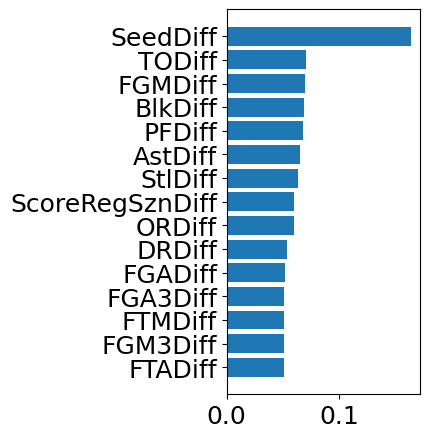

In [70]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize = (2.5,5))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.rcParams['font.size'] = 18
plt.show()

In [67]:
df_bets

,Winner,ret0,ret1,prob0,prob1,eff_ret_0,eff_ret_1,to_bet,winnings
0,0,0.010000,29.000000,0.999547,0.000453,0.009543,-0.986412,0,0.010000
1,0,0.500000,0.549451,0.674405,0.325595,0.011607,-0.495506,0,0.500000
2,0,0.400000,1.020000,0.976123,0.023877,0.366572,-0.951769,0,0.400000
3,0,6.600000,0.076923,0.049155,0.950845,-0.626418,0.023986,1,-1.000000
4,0,2.300000,0.232558,0.179817,0.820183,-0.406604,0.010923,1,-1.000000
...,...,...,...,...,...,...,...,...,...
58,1,0.280000,0.649351,0.440874,0.559126,-0.435681,-0.077805,1,0.000000
59,0,0.641026,0.300000,0.897878,0.102122,0.473440,-0.867241,0,0.641026
60,1,3.200000,0.172414,0.002088,0.997912,-0.991232,0.169966,1,0.172414
61,1,2.650000,0.204082,0.109012,0.890988,-0.602106,0.072822,1,0.204082
